In [1]:
import numpy as np
from scipy.optimize import minimize

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
global beta
global T
# it is said we can plug it
beta = 0.5
# years
T = 0.2

In [3]:
data = pd.read_pickle("data/colmiled_options.pkl")

In [4]:
data.head()

,instrument_name,timestamp,underlying_price,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp,strike
0,BTC-29SEP23-10000-C,1666479718647,19308.49,210.0,0.7831,0.0000,0.0,2022-10-23 02:01:58.647000,10000
0,BTC-29SEP23-10000-P,1666479718645,19308.49,210.0,0.3010,0.0265,0.0,2022-10-23 02:01:58.645000,10000
0,BTC-29SEP23-14000-C,1666479718642,19308.49,210.0,0.7379,0.0000,0.0,2022-10-23 02:01:58.642000,14000
0,BTC-29SEP23-14000-P,1666479718640,19308.49,210.0,0.4629,0.0855,0.0,2022-10-23 02:01:58.640000,14000
0,BTC-29SEP23-16000-C,1666479718641,19308.49,210.0,0.7185,0.4000,0.0,2022-10-23 02:01:58.641000,16000


In [5]:
def sigmaB(f, K, T, alpha, rho, v, beta = 0.5):
    first_part_of_numerator = (1-beta)**2/24 * alpha**2/(f*K)**(1-beta)
    second_part_of_numerator = (rho*beta*v*alpha)/4*(f*K)**((1-beta)/2)
    third_part_of_numerator = (2 - 3*rho**2)*v**2/24
    numerator = alpha*(1 + T*(first_part_of_numerator + 
                              second_part_of_numerator+ third_part_of_numerator))
    
    first_part_of_denominator = (1-beta)**2/24 * np.log(f/K)**2
    second_part_of_denominator = (1-beta)**4/1920 * np.log(f/K)**4
    denominator = (f*K)**((1-beta)/2)*(1 + first_part_of_denominator + second_part_of_denominator)
    
    z = v/alpha*(f*K)**((1-beta)/2)*np.log(f/K)
    
    xi = np.log((np.sqrt(1 - 2*rho*z + z**2)+z-rho)/(1-rho))
    
    return numerator/denominator * z/xi

    

In [6]:
smile = data.mark_iv.to_numpy()

In [7]:
def vol_square_error(x):
    vols = []
    for index, row in data.iterrows():
        vols.append(sigmaB(row["underlying_price"], row["strike"], T, x[0], x[1], x[2]))
    return sum((vols - smile)**2)

## Ищем параметры

In [8]:
initial_guess = [0.01, 0.00, 0.10]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None)]
res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
alpha, rho, v = res.x


In [9]:
alpha

5695.111753140356

In [10]:
rho

-0.002133375854218188

In [11]:
v

0.016833937876755484

## Теперь эти параметры в формулу для подсчета волатильности

In [12]:
sample = data.sample(1)
sample_dict = sample.iloc[0]
sample

,instrument_name,timestamp,underlying_price,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp,strike
0,BTC-29SEP23-14000-C,1666479718642,19308.49,210.0,0.7379,0.0,0.0,2022-10-23 02:01:58.642000,14000


In [18]:
sigmas = []
strikes = []
for index, row in data.iterrows():
    sigma_modeled = sigmaB(
        row.underlying_price, 
        row.strike,
        T, 
        alpha,
        rho, 
        v
    )
    sigmas.append(sigma_modeled)
    strikes.append(row.strike)

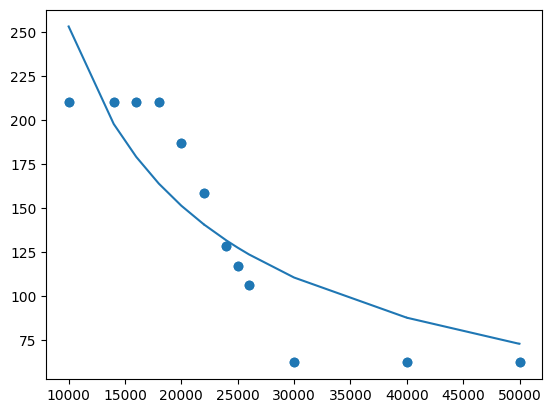

In [19]:
plt.plot(strikes, sigmas)
plt.scatter(data["strike"], data["mark_iv"])

In [15]:
def calculate_put_price():
    pass
    